In [1]:
import cv2
import zipfile
from PIL import Image
import matplotlib.pyplot as plt

from keras.preprocessing import image


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/avito-demand-prediction/train.csv
/kaggle/input/avito-demand-prediction/train_jpg_2.zip
/kaggle/input/avito-demand-prediction/train_jpg_4.zip
/kaggle/input/avito-demand-prediction/train_jpg_3.zip
/kaggle/input/avito-demand-prediction/periods_test.csv
/kaggle/input/avito-demand-prediction/test_jpg.zip
/kaggle/input/avito-demand-prediction/train_jpg_1.zip
/kaggle/input/avito-demand-prediction/test_active.csv
/kaggle/input/avito-demand-prediction/train_active.csv
/kaggle/input/avito-demand-prediction/train_jpg_0.zip
/kaggle/input/avito-demand-prediction/periods_train.csv
/kaggle/input/avito-demand-prediction/test.csv
/kaggle/input/avito-demand-prediction/sample_submission.csv
/kaggle/input/avito-demand-prediction/train_jpg.zip


In [2]:
%%time
#data = pd.read_csv('../input/avito-demand-prediction/train.csv', usecols=['price','image', 'category_name'], nrows=100)
data = pd.read_csv('../input/avito-demand-prediction/train.csv', usecols=['price','image', 'category_name'])
data.category_name.value_counts()

CPU times: user 6.26 s, sys: 590 ms, total: 6.85 s
Wall time: 6.99 s


Одежда, обувь, аксессуары       282753
Детская одежда и обувь          270359
Товары для детей и игрушки       99747
Квартиры                         83670
Телефоны                         65944
Мебель и интерьер                65035
Предложение услуг                64385
Автомобили                       62494
Ремонт и строительство           56201
Бытовая техника                  33705
Товары для компьютера            29565
Дома, дачи, коттеджи             29244
Красота и здоровье               29198
Аудио и видео                    27036
Спорт и отдых                    24881
Коллекционирование               24346
Оборудование для бизнеса         16047
Земельные участки                16038
Часы и украшения                 15566
Книги и журналы                  11819
Собаки                           11612
Игры, приставки и программы      11167
Другие животные                  11040
Велосипеды                       10638
Ноутбуки                         10297
Кошки                    

In [3]:
data = data[data['category_name']=='Одежда, обувь, аксессуары'].dropna().reset_index(drop=True)

In [4]:
data.shape

(276933, 3)

In [5]:
data

,category_name,price,image
0,"Одежда, обувь, аксессуары",500.0,9bab29a519e81c14f4582024adfebd4f11a4ac71d323a6...
1,"Одежда, обувь, аксессуары",500.0,75ce06d1f939a31dfb2af8ac55f08fa998fa336d13ee05...
2,"Одежда, обувь, аксессуары",1.0,5162fdb7d8427738370d3145647d2726546f65631e5de9...
3,"Одежда, обувь, аксессуары",800.0,df76951e5cc7073553ea3214fd2024b9f80166828a5356...
4,"Одежда, обувь, аксессуары",1000.0,1a60aa7ac1bab4fac1171650369e19d2e6872483d89032...
...,...,...,...
276928,"Одежда, обувь, аксессуары",500.0,224a4b70e48a6ce3acdc8cebe3d8df7e1740472954a766...
276929,"Одежда, обувь, аксессуары",3000.0,e1138cb112dd93a0fb12d84bec55177dbff3decd184002...
276930,"Одежда, обувь, аксессуары",150.0,96a65b018d54fe4a59614ac2574003d879635df19c80bf...
276931,"Одежда, обувь, аксессуары",200.0,3c67c7fca10a8e7a0b104248b8731394fd6871ef164b0d...


In [6]:
price_class = pd.DataFrame(data.price.value_counts()).reset_index()

In [7]:
price_class.columns = ['price', 'count']

In [8]:
data = pd.merge(data, price_class)

In [9]:
data = data[data['count']>2000].reset_index(drop=True).dropna()
data

,category_name,price,image,count
0,"Одежда, обувь, аксессуары",500.0,9bab29a519e81c14f4582024adfebd4f11a4ac71d323a6...,35518
1,"Одежда, обувь, аксессуары",500.0,75ce06d1f939a31dfb2af8ac55f08fa998fa336d13ee05...,35518
2,"Одежда, обувь, аксессуары",500.0,e27864ec1516b1227108a4013665950c8847b9c1b3f976...,35518
3,"Одежда, обувь, аксессуары",500.0,1e8f3022d62feddc1f2e68aaf37d4c312a142f01553f1b...,35518
4,"Одежда, обувь, аксессуары",500.0,b9b2edf173cb94f956a4d465b797d87455d0b6d2d108e6...,35518
...,...,...,...,...
225202,"Одежда, обувь, аксессуары",450.0,11fcc1ef4d6b6e94a527b11c63406d47327c50c5d66edc...,3010
225203,"Одежда, обувь, аксессуары",450.0,d10a85a87271f7c49ec712d0fdb6a1176ccc91909a39db...,3010
225204,"Одежда, обувь, аксессуары",450.0,602f154b6dc18914bc914b40404ebd9c4081859e0a6fc7...,3010
225205,"Одежда, обувь, аксессуары",450.0,6173c0b1eeb73732bedc591d0117308b2c62aba695fae4...,3010


In [10]:
%%time
imgzip = zipfile.ZipFile('../input/avito-demand-prediction/train_jpg.zip')
inflist = imgzip.infolist()

CPU times: user 26.5 s, sys: 869 ms, total: 27.4 s
Wall time: 27.8 s


(244, 244, 3)


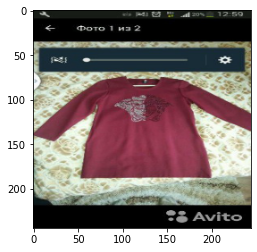

In [11]:
IMG_SIZE = 244

def im_from_zip(template, imgzip, name):
    f = template.format(name)
    #print(f)
    ifile = imgzip.open(f)
    #img = Image.open(ifile)
    img = np.asarray(Image.open(ifile))
    #img = cv2.imread(ifile)
    #img = image.load_img(ifile, target_size=(224, 224))
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    #print(img)
    #plt.imshow(img)
    #plt.show()
    return img


template = 'data/competition_files/train_jpg/{}.jpg'
name = data.image[99]
im1 = im_from_zip(template, imgzip, name)
print(im1.shape)
plt.imshow(im1)


In [12]:
def train_generator(batchsize = 1, rows = 10, scale=10):
    while True:
        ch = pd.read_csv('../input/avito-demand-prediction/train.csv', usecols=['price','image', 'category_name'], chunksize=rows * batchsize)
        for chunk in ch:
            try:
                X_train = chunk[chunk['category_name']=='Товары для детей и игрушки'].image #[::scale]
                y_raw = chunk[chunk['category_name']=='Товары для детей и игрушки'].price.astype(int) #[::scale]
                #X_train = np.reshape(X_train, (batchsize,int(rows/scale),1))
                #y_raw = np.reshape(y_raw, (batchsize,int(rows/scale),1))
            
                template = 'data/competition_files/train_jpg/{}.jpg'
            
                image_list = []
            
                for name in chunk.image:
                    image_list.append(im_from_zip(template, imgzip, name))

                yield np.array(image_list).reshape(-1, IMG_SIZE, IMG_SIZE, 3), y_raw.to_numpy()
            except:
                pass

In [13]:
data.price.unique()

array([ 500.,  800., 1000., 1500., 4000.,  400.,  300., 2000., 1200.,
        100.,  350.,  600.,  900., 2500.,  700., 3500., 5000., 3000.,
        200.,  250., 1800., 1300.,  150.,  450.])

In [14]:
data.shape

(225207, 4)

In [15]:
NCLASS = (data.price.unique().shape[0])

In [16]:
from sklearn.preprocessing import OneHotEncoder
OH = OneHotEncoder()

In [17]:
%%time
OH.fit(data.price.values.reshape(-1,1))

CPU times: user 5.62 ms, sys: 97 µs, total: 5.72 ms
Wall time: 6.52 ms


OneHotEncoder()

In [18]:
y_train = OH.transform(data.price.values.reshape(-1,1)).toarray()

In [19]:
y_train[1].reshape(-1,24)

array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]])

In [20]:
y_train.shape

(225207, 24)

In [21]:
import random
random.seed(0) 
random.choice(data.index)
#random.sample(data.index,data.index.shape[0])

221360

In [22]:
def train_generator(batchsize = 1, rows = 10, scale=10):
    while True:
                i = random.choice(data.index)
        #for i in data.index:
            #try:
                y_raw = [data.loc[i,'price']]
                template = 'data/competition_files/train_jpg/{}.jpg'
                image_list = []
                image_list.append(im_from_zip(template, imgzip, data.loc[i, 'image']))
                yield np.array(image_list).reshape(-1, IMG_SIZE, IMG_SIZE, 3), y_train[i].reshape(-1,24)
            #except:
            #    pass

In [23]:
#def resize(x_test):
#    x_test_244 = np.zeros((x_test.shape[0],244,244,x_test.shape[3]))
#    for i in range(x_test.shape[0]):
#        x_test_244[i] = cv2.resize(x_test[i], (IMG_SIZE, IMG_SIZE))
#    return x_test_244

#def chan3 (x_test):
#    inp_shape = (x_test.shape[0],x_test.shape[1],x_test.shape[2],3)
#    x_test_new = np.zeros(inp_shape)
#    x_test_new[:,:,:,0] = x_test
#    x_test_new[:,:,:,1] = x_test
#    x_test_new[:,:,:,2] = x_test
#    return resize(x_test_new)

In [24]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers


In [25]:
#num_classes = 10
input_shape = (244, 244, 3)
n_train = 1000
n_test = 100

In [26]:
model = keras.Sequential(
    [
        #keras.Input(shape=input_shape),
        #keras.applications.MobileNetV2(
        #input_shape=input_shape,
        #alpha=1.0,
        #include_top=False,
        #weights="imagenet",
        #weights=None,
        #input_tensor=None,
        #pooling=None,
        #classes=NCLASS,
        #classifier_activation="softmax",
        #**kwargs
        #),
        
        keras.applications.EfficientNetB4(
        include_top=True,
        weights=None,
        #input_tensor=None,
        input_shape=input_shape,
        pooling=None,
        classes=NCLASS,
        classifier_activation="softmax",
        #**kwargs
        )
        
        #layers.Conv2D(32, kernel_size=(2, 2), activation="relu"),
        #layers.MaxPooling2D(pool_size=(2, 2)),
        #layers.Conv2D(64, kernel_size=(2, 2), activation="relu"),
        #layers.MaxPooling2D(pool_size=(2, 2)),
        
        #layers.Flatten(),
        #layers.Dense(100, activation="relu"),
        #layers.Dropout(0.2),
        #layers.Dense(NCLASS, activation="linear"),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb4 (Functional)  (None, 24)                17716855  
Total params: 17,716,855
Trainable params: 17,591,648
Non-trainable params: 125,207
_________________________________________________________________


In [27]:
gen = train_generator()

In [28]:
X, y = next(gen)
print(X.shape)
print(y.shape)

(1, 244, 244, 3)
(1, 24)


In [29]:
batch_size = 10
epochs = 1

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
#model.compile(loss="mae", optimizer="adam", metrics=["accuracy"])

#model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)
#model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs)

In [30]:
#score = model.evaluate(x_test, y_test, verbose=0)
#print("Test loss:", score[0])
#print("Test accuracy:", score[1])

In [31]:
#epoch = 100
#steps = round(data.shape[0]/epoch)
epoch = 30
steps = 800

In [32]:
history = model.fit_generator(generator=gen,
                    epochs=epoch,
                    steps_per_epoch=steps)

Epoch 1/30
800/800 [==============================] - 67s 84ms/step - loss: 3.3046 - accuracy: 0.1125
Epoch 2/30
800/800 [==============================] - 68s 84ms/step - loss: 3.0278 - accuracy: 0.1225
Epoch 3/30
800/800 [==============================] - 68s 85ms/step - loss: 3.0896 - accuracy: 0.0975
Epoch 4/30
800/800 [==============================] - 67s 84ms/step - loss: 3.0111 - accuracy: 0.1250
Epoch 5/30
800/800 [==============================] - 68s 85ms/step - loss: 3.0717 - accuracy: 0.1275
Epoch 6/30
800/800 [==============================] - 69s 86ms/step - loss: 2.9976 - accuracy: 0.1300
Epoch 7/30
800/800 [==============================] - 69s 86ms/step - loss: 2.9949 - accuracy: 0.1225
Epoch 8/30
800/800 [==============================] - 68s 86ms/step - loss: 2.9814 - accuracy: 0.1500
Epoch 9/30
800/800 [==============================] - 70s 88ms/step - loss: 2.9615 - accuracy: 0.1350
Epoch 10/30
800/800 [==============================] - 71s 89ms/step - loss: 2.940

In [33]:
model.save('mobilenet')

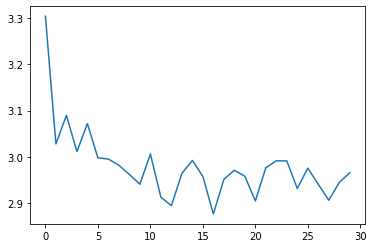

In [34]:
plt.plot(history.history['loss'])

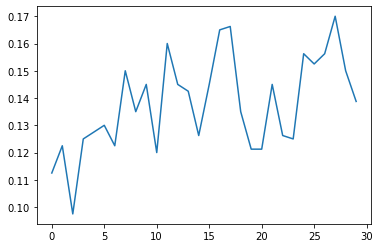

In [35]:
plt.plot(history.history['accuracy'])

In [36]:
steps = 1000
predict = model.predict_generator(gen,
                    #epochs=epoch,
                    steps, verbose=1)

1000/1000 [==============================] - 19s 19ms/step


(array([ 27.,  20.,  73.,   0.,   0., 361.,   0.,   0.,   0., 519.]),
 array([ 8. ,  8.9,  9.8, 10.7, 11.6, 12.5, 13.4, 14.3, 15.2, 16.1, 17. ]),
 <a list of 10 Patch objects>)

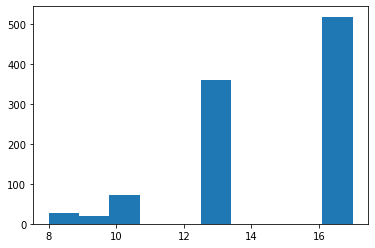

In [37]:
plt.hist(predict.argmax(axis=1))

In [38]:
steps = 1000
predict = model.predict_generator(gen,
                    #epochs=epoch,
                    steps, verbose=1)

1000/1000 [==============================] - 19s 19ms/step


(array([ 40.,  89.,   0., 333.,   0.,   0., 536.,   0.,   1.,   1.]),
 array([ 8. ,  9.4, 10.8, 12.2, 13.6, 15. , 16.4, 17.8, 19.2, 20.6, 22. ]),
 <a list of 10 Patch objects>)

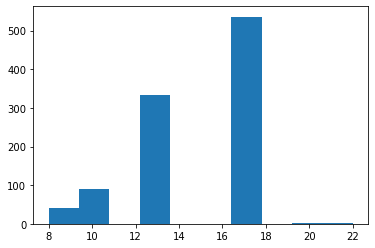

In [39]:
plt.hist(predict.argmax(axis=1))

In [40]:
evl = model.evaluate_generator(gen, steps)

In [41]:
evl

[33.83516311645508, 0.06400000303983688]

In [42]:
import pickle
with open("encoder", "wb") as f: 
    pickle.dump(OH, f)